In [2]:
import pymc3 as pm
import arviz as az
import numpy as np 
import scipy.stats as scistats
import scipy.io as sio 
from matplotlib import pyplot as plt 
import scipy.integrate as integrate
import theano.tensor as tt

In [ ]:
dataDict = sio.loadmat("mcmc_material_linear_hardening_N20.mat")
dataDict.keys()

strain_m = dataDict["strain_m"].squeeze()
stress_m = dataDict["stress_m"].squeeze()


In [ ]:
def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

In [ ]:
def stress(e,sigma_y,H,E):
    h = lambda x: tt.switch(x < 0, 0, 1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

In [ ]:
x = strain_m
y = stress_m


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, E, H, sigma_y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0718a20690>,
      dtype=object)

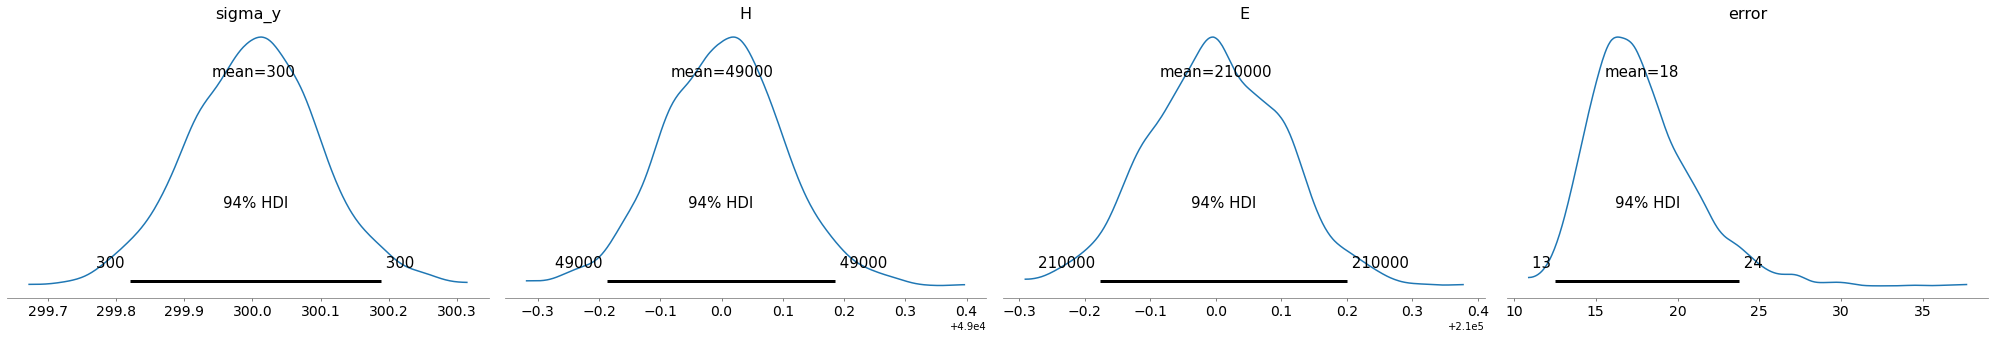

In [ ]:
import pymc3 as pm
import arviz as az
with pm.Model() as model:
    # define priors
    sigma_y =  pm.Normal('sigma_y', 300, 0.1)
    H = pm.Normal('H', 49000, 0.1)
    E =  pm.Normal('E', 210000, 0.1)

    s = pm.Exponential('error', 0.01) #play around with 
    
    # predictions
    obs = pm.Normal('observation', stress(x, sigma_y, H, E), s, observed=y)
    
    # use MCMC to sample
    trace = pm.sample(return_inferencedata=True)
    
az.plot_posterior(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, E, H, sigma_y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07187d3bd0>,
      dtype=object)

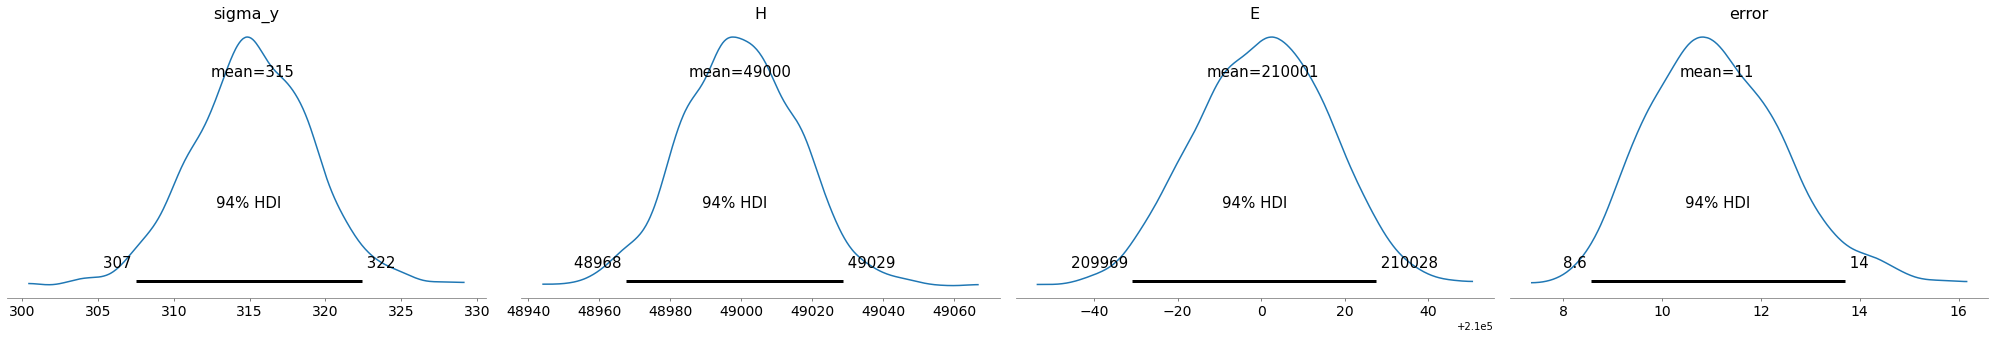

In [ ]:
with pm.Model() as predictive_model:
    sigma_y =  pm.Normal('sigma_y', 300, 0.1)
    H = pm.Normal('H', 49000, 0.1)
    E =  pm.Normal('E', 210000, 0.1)
    
    s = pm.Exponential('error', 1) #play around with 
    
    x_ = pm.Data('features', x) # a data container, can be changed
    
    obs = pm.Normal('observation', stress(x_, sigma_y, H, E), s, observed=y)
    
    trace = pm.sample()

az.plot_posterior(trace)

In [ ]:
x_new = np.linspace(0-0.001, strain_m[-1]+0.002, 500) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']

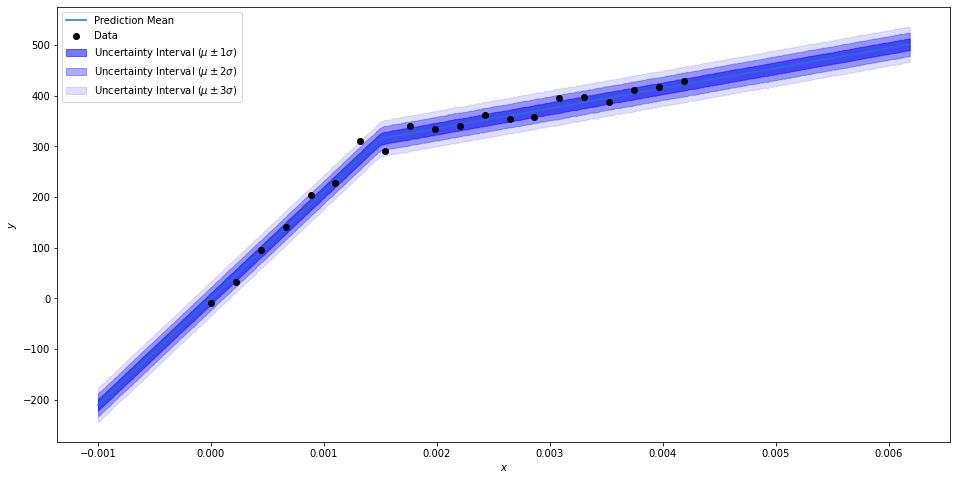

In [ ]:
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 1*y_std, y_mean + 1*y_std, alpha=0.53,color='b', label='Uncertainty Interval ($\mu\pm1\sigma$)')
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.33,color='b', label='Uncertainty Interval ($\mu\pm2\sigma$)')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.13,color='b', label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')

In [3]:
dataDict = sio.loadmat("q4_linear_regression_model.mat")
dataDict.keys()

training_x = dataDict["training_x"].squeeze()
training_y = dataDict["training_y"].squeeze()

In [4]:
x = training_x
y = training_y

In [58]:
pm.Normal?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, w2, w1, w0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3796e313d0>,
      dtype=object)

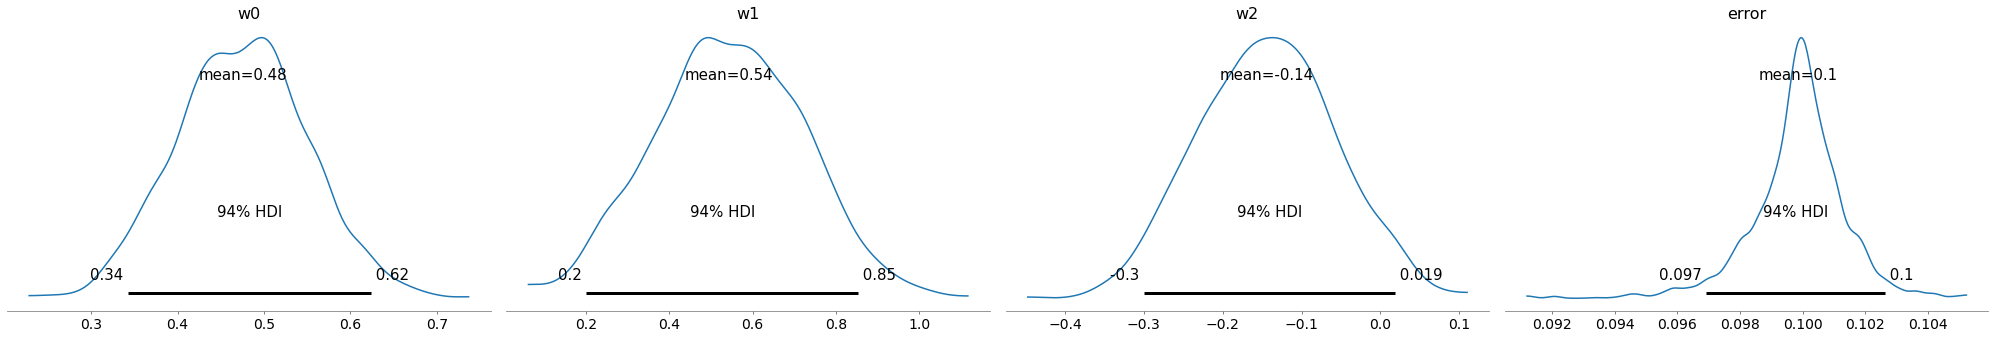

In [78]:
with pm.Model() as predictive_model:
    w0 =  pm.Normal('w0', 0, 1)
    w1 = pm.Normal('w1', 0, 1)
    w2 =  pm.Normal('w2', 0, 1)
    s = pm.Laplace('error', 0.1,0.001)
    
    x_ = pm.Data('features', x) # a data container, can be changed
    
    obs = pm.Normal('observation', w0 + x_*w1 + w2*x_**2, s, observed=y)
    
    trace = pm.sample()

az.plot_posterior(trace)

In [79]:
x_new = np.linspace(-1, 3, 500) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']

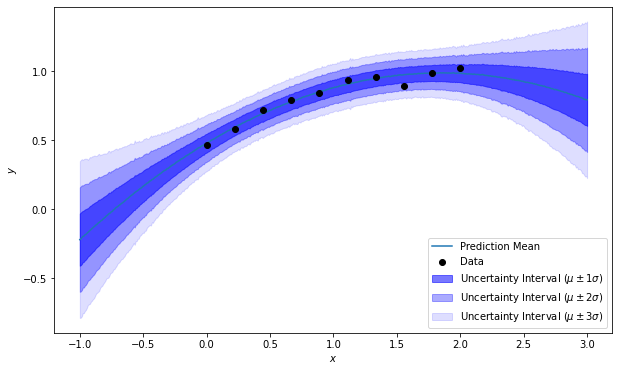

In [45]:
# Normal with 0.1 variance 

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 1*y_std, y_mean + 1*y_std, alpha=0.53,color='b', label='Uncertainty Interval ($\mu\pm1\sigma$)')
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.33,color='b', label='Uncertainty Interval ($\mu\pm2\sigma$)')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.13,color='b', label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')

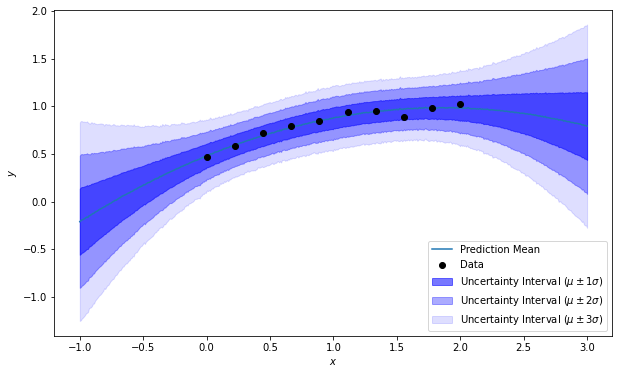

In [54]:
# Laplace with 0.001 variance 

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 1*y_std, y_mean + 1*y_std, alpha=0.53,color='b', label='Uncertainty Interval ($\mu\pm1\sigma$)')
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.33,color='b', label='Uncertainty Interval ($\mu\pm2\sigma$)')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.13,color='b', label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')

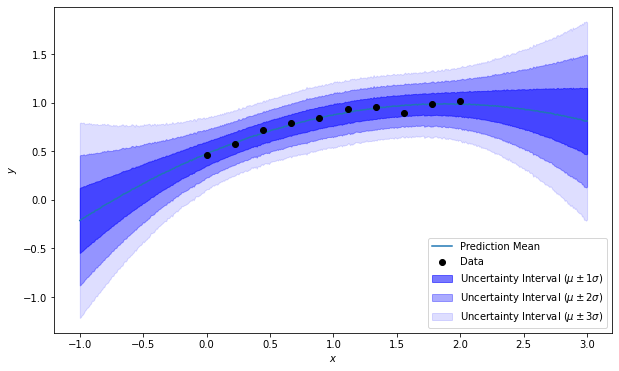

In [80]:
# Laplace with 0.001 variance 

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 1*y_std, y_mean + 1*y_std, alpha=0.53,color='b', label='Uncertainty Interval ($\mu\pm1\sigma$)')
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.33,color='b', label='Uncertainty Interval ($\mu\pm2\sigma$)')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.13,color='b', label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')